In [2]:
import pandas as pd
from pandas_ods_reader import read_ods
import seaborn as sn
import matplotlib.pyplot as plt
import tqdm
import os
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from data_loader import load_datasets, nee_cumulative_to_daily, to_pd

### This file is used to find correlation between Net biome productivity, soil organic carbon, ecosystem co2 and the rest of the properties


#### Measured using Pearson's coefficient

#### Target dict contains the target variables from each file 

In [3]:
target = 'NEE'

model = ['rcef_RandomForestRegressor', 'rcef_RidgeCV', 'rcef_XGBRegressor', 'xgboost'] 

extracted_features = model[-1]

In [ ]:
dirs = ['warm_temp_maize_soybean_irrigated', 'warm_temp_maize-soybean_dryland', 'cool_temp_maize_soybean']

datasets = load_datasets(dirs, '/csv_outs/with_plant_soil_details/')

df_dry = nee_cumulative_to_daily(to_pd(datasets['warm_temp_maize-soybean_dryland'], True, True))
df_irr = nee_cumulative_to_daily(to_pd(datasets['warm_temp_maize_soybean_irrigated'], True, True))
df_cool = nee_cumulative_to_daily(to_pd(datasets['cool_temp_maize_soybean'], True, True))

df = pd.concat([df_dry,df_irr, df_cool])

y = df[target].copy()

In [10]:
# no GPT / copilot baby
def get_correlations(data: dict, file_name: str, target_vars: list, threshold: int ) -> dict:
    corr_dict = {}
    for target_var in target_vars:
        corr = pd.Series([])
        target_data = data[target_var]
        
        for file in data:
            df = data[file]
            
            if target_var not in df.columns:
                df[target_var] = target_data
                
            c = df.corr()[target_var]
            c = c[abs(c) > threshold]
            c = c.where(c.index != target_var).dropna()
            corr = pd.concat([corr, c])
        
        corr = corr.sort_values(ascending=False)
        corr_dict[target_var] = corr
    
    return corr_dict     

In [62]:
cors = df.corr()['NEE'].sort_values(ascending=False).dropna().drop(['NEE', 'ECO_NPP', 'NPP', 'ECO_GPP', 'GPP', 'CAN_GPP', 'ECO_RA', 'CAN_RA', 'D_AUTO_RESP'])

cors = cors[cors.abs() > 0.7] 

In [63]:
cors

UPTK_N           0.913617
D_ET             0.912239
D_TRANSPN        0.896359
D_PRECN          0.890435
D_NH3_FLUX       0.889435
D_O2_FLUX        0.873669
NET_N_MIN        0.869951
NODE_NO.         0.864529
DOY              0.798477
UPTK_P           0.797455
NET_P_MIN        0.759673
AUTO_RESP       -0.721687
H2_FLUX         -0.722447
ECO_RH          -0.749896
CO2_FLUX        -0.850166
NET_PL_EXCH_N   -0.868318
ABV_GRD_RESP    -0.896393
Name: NEE, dtype: float64

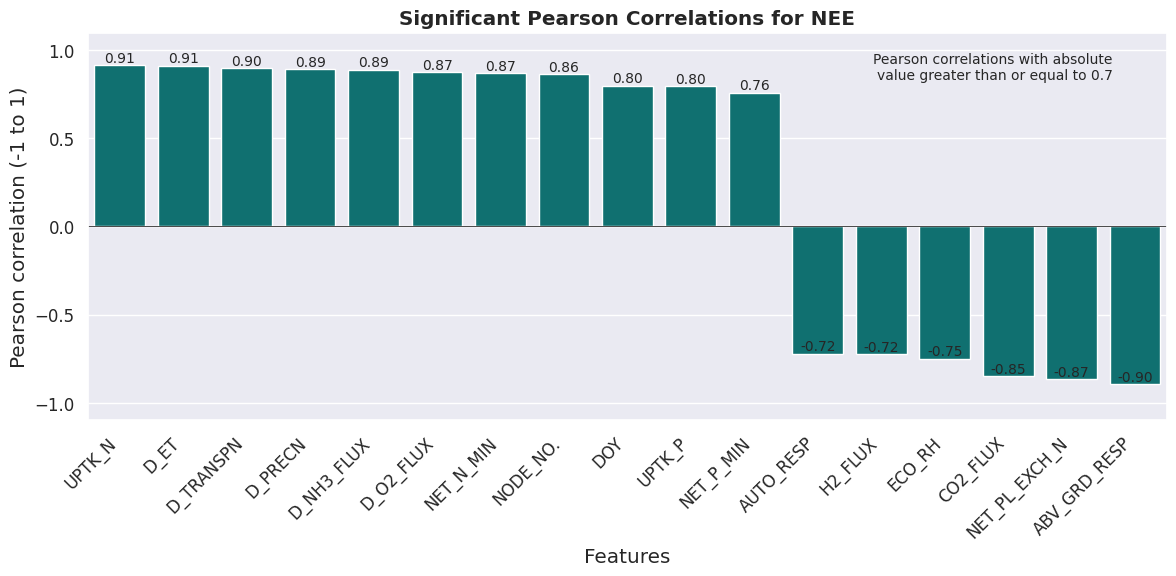

In [64]:
sns.set_style('whitegrid')

plt.figure(figsize=(12, 6))
sns.set(font_scale=1.2)

sns.barplot(x=cors.index, y=cors, color='teal')


plt.xlabel('Features')
plt.ylabel('Pearson correlation (-1 to 1)')
plt.title('Significant Pearson Correlations for ' + cors.name, fontweight='bold')


plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks([-1, -0.5, 0, 0.5, 1], fontsize=12)
plt.ylim(-1.1, 1.1)


plt.axhline(0, color='black', linewidth=0.5)


for i, v in enumerate(cors):
    if abs(v) >= 0.7:
        plt.annotate(f"{v:.2f}", xy=(i, v), ha='center', va='bottom', fontsize=10)


plt.text(0.95, 0.95, "Pearson correlations with absolute\nvalue greater than or equal to 0.7", 
         ha='right', va='top', transform=plt.gca().transAxes, fontsize=10)

plt.tight_layout()
plt.show()